<a href="https://colab.research.google.com/github/Sozgen1/Lung-Cancer-Detection-With-CNN/blob/main/LUNGCANCERCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Modüller**

In [ ]:

import os
import time
import shutil
import pathlib
import itertools
from PIL import Image


import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:

data_dir = '/content/drive/MyDrive/Oruntu_Tanima/lung_colon_image_set'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath, f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path, file)
            filepaths.append(fpath)

            if f == 'colon_aca':
                labels.append('Colon Adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')


Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
df

filepaths  \
0      /content/drive/MyDrive/Oruntu_Tanima/lung_colo...   
1      /content/drive/MyDrive/Oruntu_Tanima/lung_colo...   
2      /content/drive/MyDrive/Oruntu_Tanima/lung_colo...   
3      /content/drive/MyDrive/Oruntu_Tanima/lung_colo...   
4      /content/drive/MyDrive/Oruntu_Tanima/lung_colo...   
...                                                  ...   
25081  /content/drive/MyDrive/Oruntu_Tanima/lung_colo...   
25082  /content/drive/MyDrive/Oruntu_Tanima/lung_colo...   
25083  /content/drive/MyDrive/Oruntu_Tanima/lung_colo...   
25084  /content/drive/MyDrive/Oruntu_Tanima/lung_colo...   
25085  /content/drive/MyDrive/Oruntu_Tanima/lung_colo...   

                             labels  
0              Colon Adenocarcinoma  
1              Colon Adenocarcinoma  
2              Colon Adenocarcinoma  
3              Colon Adenocarcinoma  
4              Colon Adenocarcinoma  
...                             ...  
25081  Lung Squamous Cell Carcinoma  
25082  Lung Squamous Cell Carcinoma  
25083  Lung Squamous Cell Carcinoma  
25084  Lung Squamous Cell Carcinoma  
25085  Lung Squamous Cell Carcinoma  

[25086 rows x 2 columns]

In [ ]:
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)


strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [ ]:

batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 20068 validated image filenames belonging to 5 classes.
Found 2509 validated image filenames belonging to 5 classes.
Found 2509 validated image filenames belonging to 5 classes.


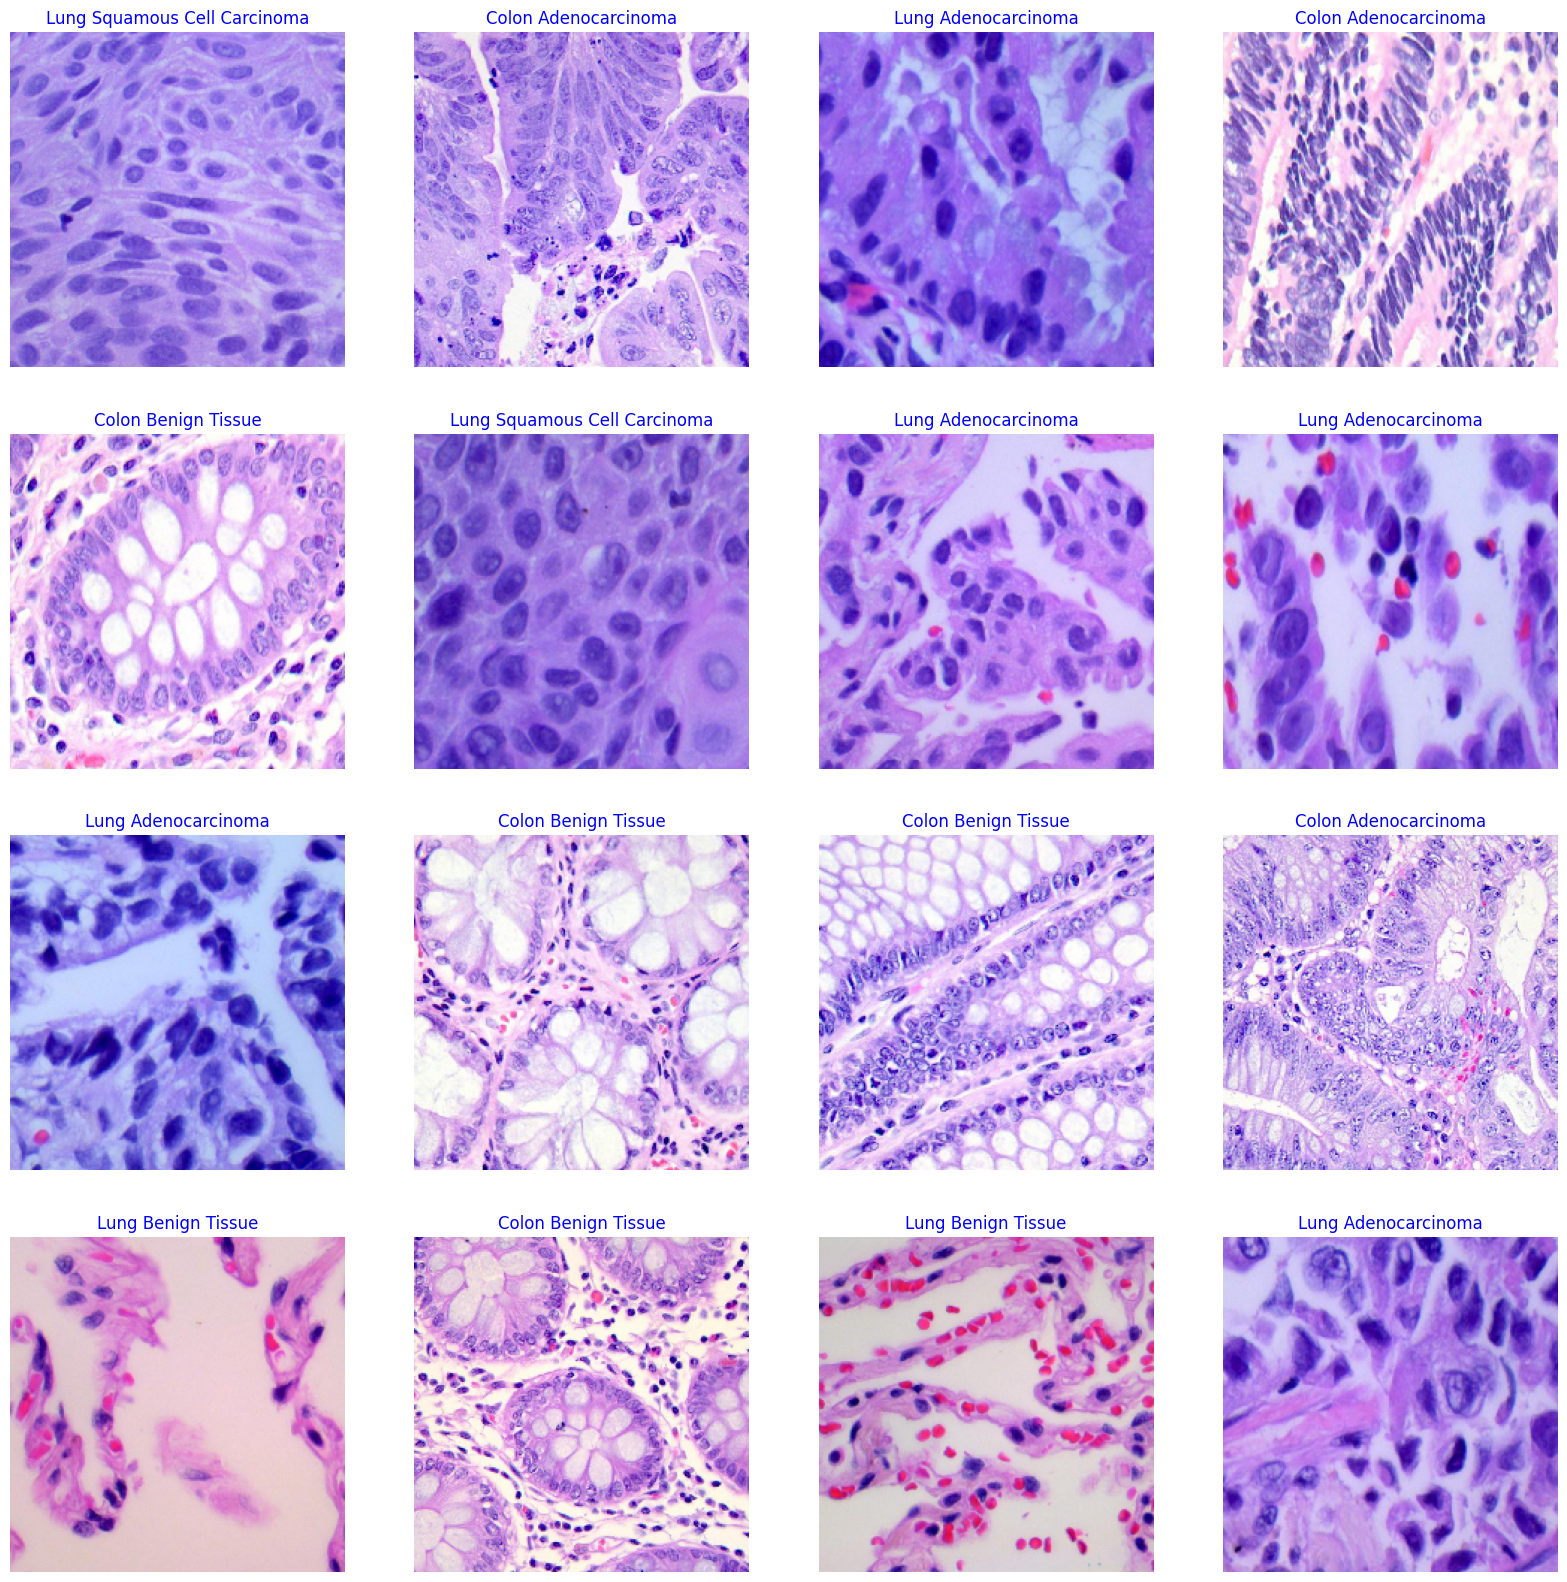

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Görüntü boyutları ve kanal sayısı
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Sınıf sayısı (örneğin, sınıf isimleri eğitim jeneratöründen alınabilir)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(64, kernel_size=(3,3), padding="same", activation="relu", input_shape=img_shape),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(class_count, activation="softmax")
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()  # Model mimarisini özetler


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                        

In [ ]:
epochs = 1

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False)

  2/314 [..............................] - ETA: 13:48:30 - loss: 3.9783 - accuracy: 0.2812

KeyboardInterrupt: 

In [ ]:

tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'


plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())


cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))